In [2]:
%run Common.ipynb

import os.path
import pandas as pd

#!pip install surprise
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection.validation import cross_validate

np.set_printoptions(suppress=True,floatmode='maxprec_equal')

In [3]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [4]:
# define some trimming functions

# get unpopular movies
movie_rating_count = ratings_df.groupby('movieId').movieId.agg('count')
unpopular_movie_ids = np.array(movie_rating_count.loc[movie_rating_count <= 2].index)
# the surprise library treats all user/item ids as strings, so convert to strings
unpopular_movie_ids = unpopular_movie_ids.astype(str)

# trim out unpopular movies
def trim_unpopular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[~df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# trim out popular movies
def trim_popular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# get high variance movies
df_var_count = pd.DataFrame(ratings_df.groupby('movieId').rating.agg(['var','count']).dropna())
# retain only rows with var >= 2.0 and count >= 5
df_var_count = df_var_count.loc[(df_var_count['count'] >= 5) & (df_var_count['var'] >= 2.0)]
high_var_movie_ids = np.array(df_var_count.index).astype(str)

# trim out low variance
def trim_low_variance(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(high_var_movie_ids)]
    return df_testset.values.tolist()

In [5]:
# utility function to cross validate and score
def cross_validate_and_score(nmf_k, kfold, trim_func):
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    for trainset, testset in kfold.split(data):
        nmf = NMF(n_factors=nmf_k)
        testset_trimmed = trim_func(testset)
        if len(testset_trimmed) > 0:
            nmf.fit(trainset)
            predictions = nmf.test(testset_trimmed, verbose=False)
            test_rmse = np.append(test_rmse, accuracy.rmse(predictions, verbose=False))
            test_mae = np.append(test_mae, accuracy.mae(predictions, verbose=False))
        else:
            test_rmse = np.append(test_rmse, 0)
            test_mae = np.append(test_mae, 0)
        
    return {'test_rmse_avg':test_rmse.mean(), 'test_mae_avg':test_mae.mean()}

In [6]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [7]:
cols = ['k','Avg RMSE', 'Avg MAE']

k_list = np.linspace(2,50,25).astype(int)
k_list

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50])

<h1>Question 19</h1>

In [7]:
df_nmf_popular_measures = pd.DataFrame(columns=cols)

for nmf_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(nmf_k, KFold(n_splits=10), trim_unpopular)
        
    df_nmf_popular_measures = df_nmf_popular_measures.append({cols[0]:nmf_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_nmf_popular_measures.set_index('k', inplace=True)


In [8]:
df_nmf_popular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.169608  0.993460
4.0   1.055173  0.870824
6.0   0.995751  0.804327
8.0   0.957187  0.761142
10.0  0.938884  0.737126
12.0  0.925365  0.719350
14.0  0.920092  0.708665
16.0  0.916679  0.703388
18.0  0.918555  0.700772
20.0  0.919151  0.697721

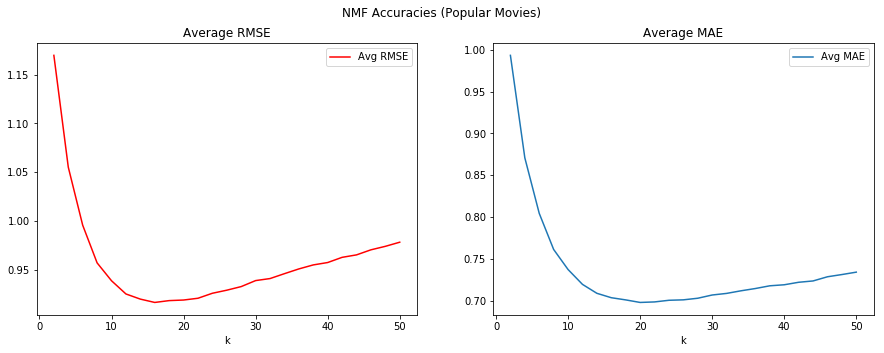

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("NNMF Accuracies (Popular Movies)")
df_nmf_popular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", xticks=np.linspace(0,50,6), color='red')
_ = df_nmf_popular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", xticks=np.linspace(0,50,6))

In [10]:
print('The  minimum average RMSE is: %4.6f'%df_nmf_popular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 0.916679


<h1>Question 20</h1>

In [14]:
df_nmf_unpopular_measures = pd.DataFrame(columns=cols)

for nmf_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(nmf_k, KFold(n_splits=10), trim_popular)
        
    df_nmf_unpopular_measures = df_nmf_unpopular_measures.append({cols[0]:nmf_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_nmf_unpopular_measures.set_index('k', inplace=True)


In [15]:
df_nmf_unpopular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.272762  1.011267
4.0   1.267844  1.004518
6.0   1.256075  0.991947
8.0   1.253091  0.989236
10.0  1.240347  0.976026
12.0  1.237437  0.975063
14.0  1.232976  0.971656
16.0  1.241052  0.976295
18.0  1.229282  0.966925
20.0  1.226656  0.960503

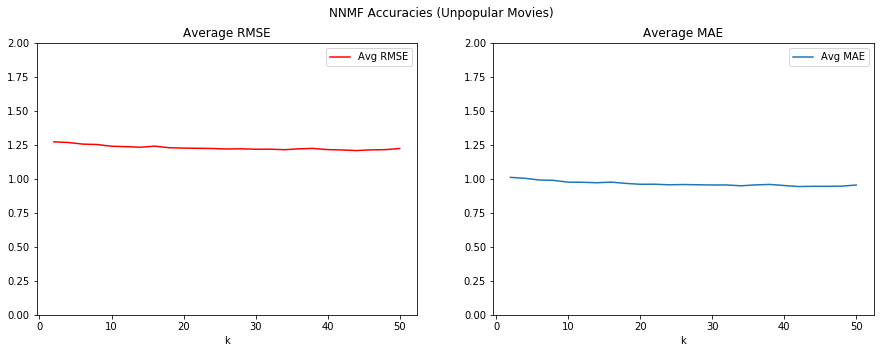

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("NNMF Accuracies (Unpopular Movies)")
df_nmf_unpopular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(0,2), xticks=np.linspace(0,50,6), color='red')
_ = df_nmf_unpopular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0,2), xticks=np.linspace(0,50,6))

In [18]:
print('The  minimum average RMSE is: %4.6f'%df_nmf_unpopular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.208591


<h1>Question 21</h1>

In [8]:
df_nmf_high_var_measures = pd.DataFrame(columns=cols)

for nmf_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(nmf_k, KFold(n_splits=10), trim_low_variance)
        
    df_nmf_high_var_measures = df_nmf_high_var_measures.append({cols[0]:nmf_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_nmf_high_var_measures.set_index('k', inplace=True)


In [9]:
df_nmf_high_var_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.631961  1.397243
4.0   1.628934  1.371457
6.0   1.628992  1.367363
8.0   1.568103  1.317024
10.0  1.574464  1.310944
12.0  1.552208  1.315728
14.0  1.545181  1.272186
16.0  1.535718  1.260890
18.0  1.581608  1.307213
20.0  1.568927  1.289948

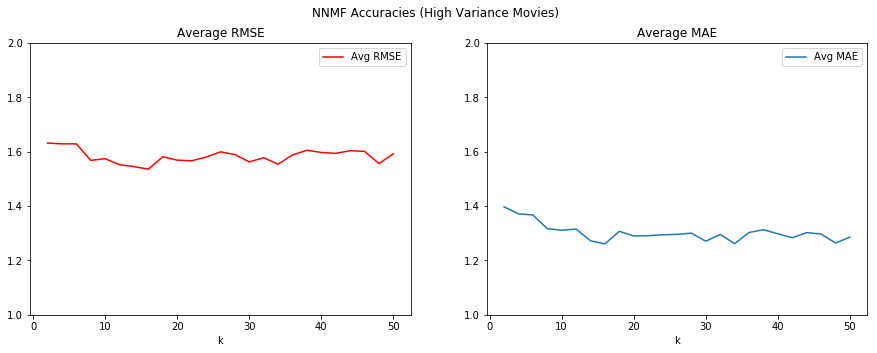

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("NNMF Accuracies (High Variance Movies)")
df_nmf_high_var_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(1,2.0), xticks=np.linspace(0,50,6), color='red')
_ = df_nmf_high_var_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(1,2.0), xticks=np.linspace(0,50,6))

In [11]:
print('The  minimum average RMSE is: %4.6f'%df_nmf_high_var_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.535718
